<a href="https://colab.research.google.com/github/deedf/covid_data/blob/main/covid_vaccine_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# First run this and restart the runtime.

%pip install matplotlib pandas ckanapi --upgrade


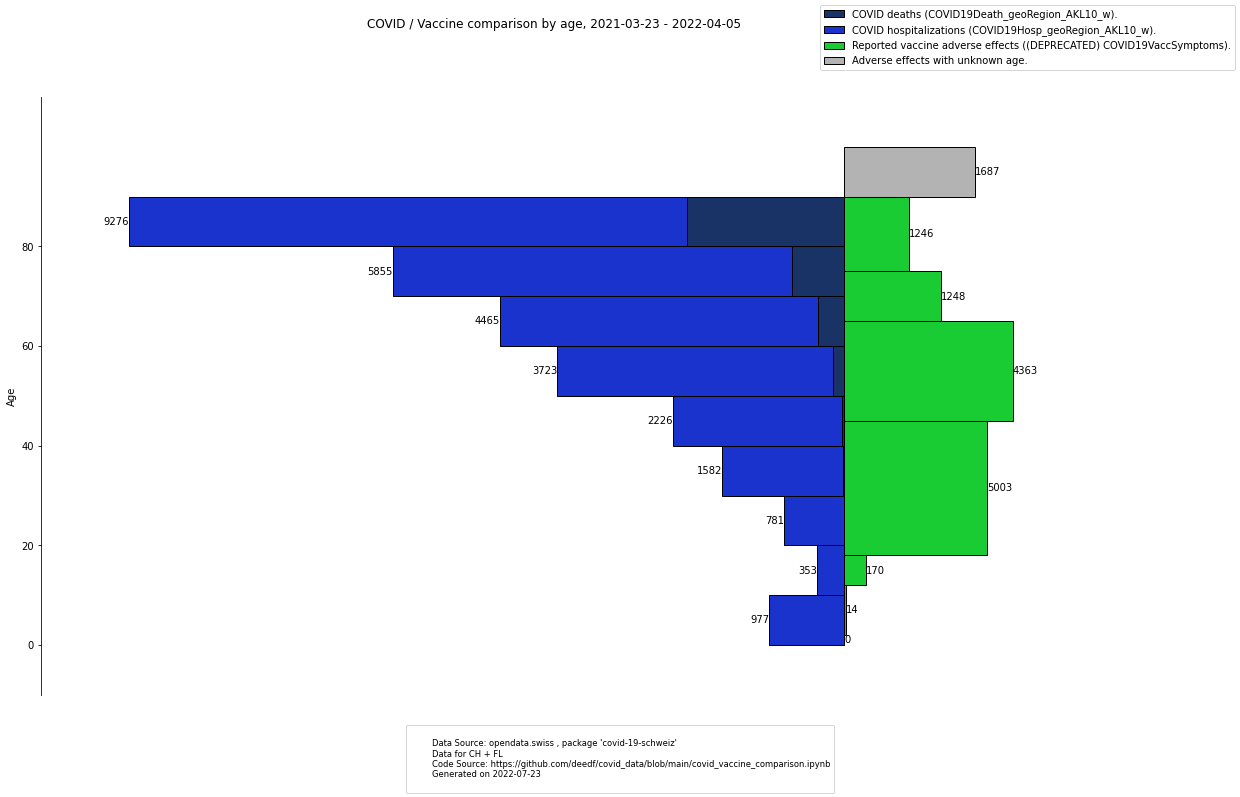

In [1]:
from collections import namedtuple
from datetime import date, datetime
from typing import Any, Dict, List, Tuple

import matplotlib.pyplot as plt
import pandas as pd
from ckanapi import RemoteCKAN
from matplotlib.patches import Rectangle


DATASET_NAME = "covid-19-schweiz"
CKAN_API_URL = "https://ckan.opendata.swiss/"

START_DATE = date(2021, 3, 23)
END_DATE = date(2022, 4, 5)
DEATH_COLOR = (0.1, 0.2, 0.4)
HOSP_COLOR = (0.1, 0.2, 0.8)
SYMPTOM_COLOR = (0.1, 0.8, 0.2)
DEATH_UNKNOWN_COLOR = (0.5, 0.5, 0.5)
HOSP_UNKNOWN_COLOR = (0.6, 0.6, 0.6)
SYMPTOM_UNKNOWN_COLOR = (0.7, 0.7, 0.7)
TRANSPARENT_COLOR = (0, 0, 0, 0)

# Used to pick the vertical position and height of each age class
AGE_BARS = pd.DataFrame(
    [
        ("0 - 9", 0, 10),
        ("10 - 19", 10, 10),
        ("20 - 29", 20, 10),
        ("30 - 39", 30, 10),
        ("40 - 49", 40, 10),
        ("50 - 59", 50, 10),
        ("60 - 69", 60, 10),
        ("70 - 79", 70, 10),
        ("80+", 80, 10),
        (
            "Unbekannt",
            90,
            10,
        ),
        ("0 - 1", 0, 2),
        ("12 - 17", 12, 6),
        ("18 - 44", 18, 27),
        ("2 - 11", 2, 10),
        ("45 - 64", 45, 20),
        ("65 - 74", 65, 10),
        ("75+", 75, 15),
        (
            "unknown",
            90,
            10,
        ),
    ],
    columns=["age", "y", "height"],
).set_index("age")

CovidData = namedtuple("CovidData", ["hosp", "death", "symptoms"])


def _get_all_data(
    death: Dict[str, Any], hosp: Dict[str, Any], symptoms: Dict[str, Any], at_date: date
) -> CovidData:
    iso_calendar = date.isocalendar(at_date)
    date_iso = int(str(iso_calendar[0]) + str(iso_calendar[1]))
    p = pd.read_csv(death["download_url"])
    death_data = (
        p[(p["datum"] == date_iso) & (p["geoRegion"] == "CHFL")]
        .set_index("altersklasse_covid19")["sumTotal"]
        .groupby(level=0)
        .sum()
    )
    p = pd.read_csv(hosp["download_url"])
    hosp_data = (
        p[(p["datum"] == date_iso) & (p["geoRegion"] == "CHFL")]
        .set_index("altersklasse_covid19")["sumTotal"]
        .groupby(level=0)
        .sum()
    )
    p = pd.read_csv(symptoms["download_url"])
    symptom_data = (
        p[
            (p["date"] == at_date.isoformat())
            & (p["geoRegion"] == "CHFL")
            & (p["vaccine"] == "all")
            & (p["age_group"] != "all")
            & (p["severity"] == "all")
        ]
        .set_index("age_group")["sumTotal"]
        .groupby(level=0)
        .sum()
    )
    return CovidData(hosp_data, death_data, symptom_data)


def _build_graph(
    death: Dict[str, Any], hosp: Dict[str, Any], symptoms: Dict[str, Any]
) -> None:
    start = _get_all_data(death, hosp, symptoms, START_DATE)
    end = _get_all_data(death, hosp, symptoms, END_DATE)
    counts = CovidData(
        pd.DataFrame(end.hosp - start.hosp).join(AGE_BARS, how="inner"),
        pd.DataFrame(end.death - start.death).join(AGE_BARS, how="inner"),
        pd.DataFrame(end.symptoms - start.symptoms).join(AGE_BARS, how="inner"),
    )
    plt.rcdefaults()
    fig, plot = plt.subplots()
    fig.suptitle(f"COVID / Vaccine comparison by age, {START_DATE} - {END_DATE}")
    fig.set_size_inches(19, 11, forward=True)
    death_known = counts.death
    death_known = death_known[(death_known.index != "Unbekannt")]
    b = plot.barh(
        y=death_known.y,
        width=-death_known.sumTotal / death_known.height,
        left=0,
        height=death_known.height,
        align="edge",
        color=DEATH_COLOR,
        edgecolor=(0, 0, 0),
        linewidth=1,
        label=f"COVID deaths ({death['display_name']['en']}).",
    )
    if counts.death.sumTotal["Unbekannt"] > 0:
        death_unknown = counts.death
        death_unknown = death_unknown[(death_unknown.index == "Unbekannt")]
        b = plot.barh(
            y=death_unknown.y,
            width=-death_unknown.sumTotal / death_unknown.height,
            left=0,
            height=death_unknown.height,
            align="edge",
            color=DEATH_UNKNOWN_COLOR,
            edgecolor=(0, 0, 0),
            linewidth=1,
            label="Death with unknown age.",
        )
    hosp_known = counts.hosp
    hosp_known = hosp_known[(hosp_known.index != "Unbekannt")]
    b = plot.barh(
        y=hosp_known.y,
        width=-hosp_known.sumTotal / hosp_known.height,
        left=-death_known.sumTotal / death_known.height,
        height=hosp_known.height,
        align="edge",
        color=HOSP_COLOR,
        edgecolor=(0, 0, 0),
        linewidth=1,
        label=f"COVID hospitalizations ({hosp['display_name']['en']}).",
    )
    plot.bar_label(b, hosp_known.sumTotal + death_known.sumTotal)
    if counts.hosp.sumTotal["Unbekannt"] > 0:
        hosp_unknown = counts.hosp
        hosp_unknown = hosp_unknown[(hosp_unknown.index == "Unbekannt")]
        b = plot.barh(
            y=hosp_unknown.y,
            width=-hosp_unknown.sumTotal / hosp_unknown.height,
            left=-death_unknown.sumTotal / death_unknown.height,
            height=hosp_unknown.height,
            align="edge",
            color=HOSP_UNKNOWN_COLOR,
            edgecolor=(0, 0, 0),
            linewidth=1,
            label="Hospitalization with unknown age.",
        )
        plot.bar_label(b, hosp_unknown.sumTotal + death_unknown.sumTotal)
    symptom_known = counts.symptoms
    symptom_known = symptom_known[(symptom_known.index != "unknown")]
    b = plot.barh(
        y=symptom_known.y,
        width=symptom_known.sumTotal / symptom_known.height,
        left=0,
        height=symptom_known.height,
        align="edge",
        color=SYMPTOM_COLOR,
        edgecolor=(0, 0, 0),
        linewidth=1,
        label=f"Reported vaccine adverse effects ({symptoms['display_name']['en']}).",
    )
    plot.bar_label(b, symptom_known.sumTotal)
    if counts.symptoms.sumTotal["unknown"] > 0:
        symptom_unknown = counts.symptoms
        symptom_unknown = symptom_unknown[(symptom_unknown.index == "unknown")]
        b = plot.barh(
            y=symptom_unknown.y,
            width=symptom_unknown.sumTotal / symptom_unknown.height,
            left=0,
            height=symptom_unknown.height,
            align="edge",
            color=SYMPTOM_UNKNOWN_COLOR,
            edgecolor=(0, 0, 0),
            linewidth=1,
            label="Adverse effects with unknown age.",
        )
        plot.bar_label(b, symptom_unknown.sumTotal)

    plot.xaxis.set_visible(False)
    plot.set_ylabel("Age")
    plot.set_yticks([0, 20, 40, 60, 80])
    fig.legend()
    more_legends =f"""
Data Source: opendata.swiss , package '{DATASET_NAME}'
Data for CH + FL
Code Source: https://github.com/deedf/covid_data/blob/main/covid_vaccine_comparison.ipynb
Generated on {datetime.now().strftime('%Y-%m-%d')}
"""
    fig.legend([Rectangle(xy=(0, 0), width=10, height=10, color=TRANSPARENT_COLOR)],[more_legends], fontsize="small", loc="lower center")
    plt.margins(0.1, 0.1)
    plot.spines["top"].set_visible(False)
    plot.spines["right"].set_visible(False)
    plot.spines["bottom"].set_visible(False)
    plt.show()


client = RemoteCKAN(CKAN_API_URL)
dataset = client.call_action("package_show", {"name_or_id": DATASET_NAME})
resource_map = dict([(r["identifier"], r) for r in dataset["resources"]])
_build_graph(
    resource_map["weekly-death-age-range-csv"],
    resource_map["weekly-hosp-age-range-csv"],
    resource_map["daily-vacc-symptoms-csv"],
)


# New Section